# Import Important Library

In [3]:
# Import matplotlib library
import matplotlib.pyplot as plt

# Import scikit-learn library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import numpy as np


# Import LFW Dataset

In [4]:
# this command will download the LFW_people's dataset (Labeled Faces in the Wild) to hard disk.
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)
 
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
 
# Instead of providing 2D data, X has data already in the form  of a vector that
# is required in this approach.
X = lfw_people.data
n_features = X.shape[1]
 
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
 
# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

URLError: <urlopen error [WinError 10054] An existing connection was forcibly closed by the remote host>

In [26]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

# Plot the images of the dataset

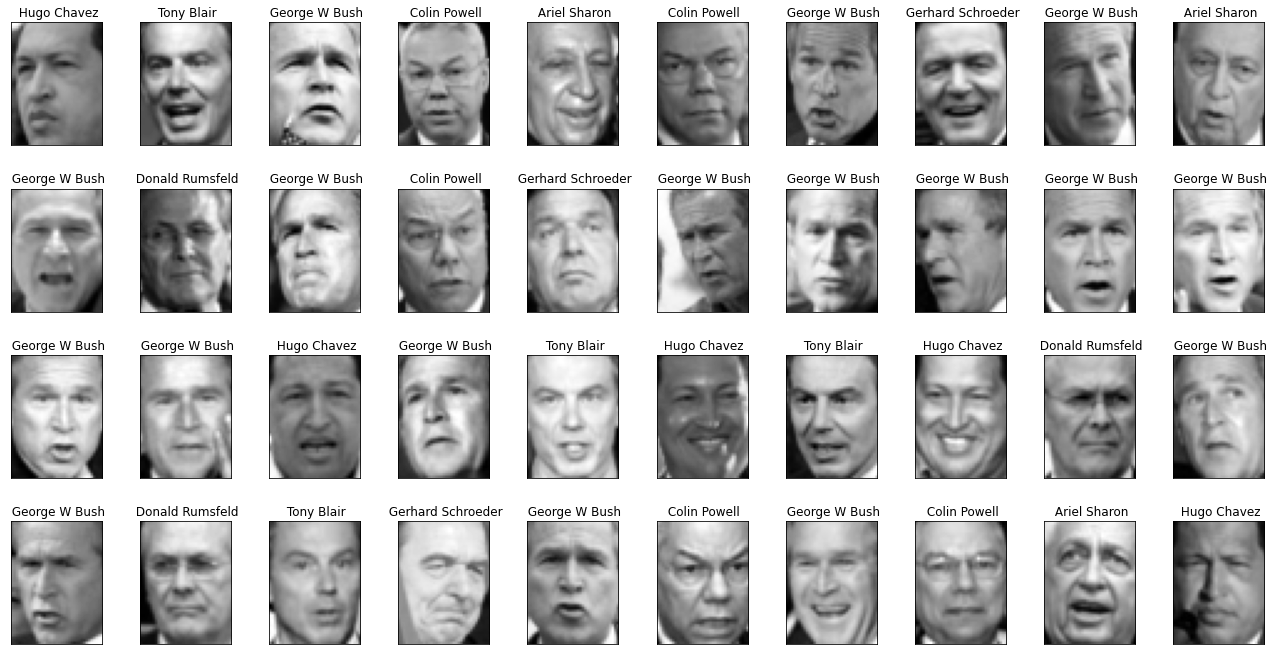

In [3]:
# Function to plot images in 3 * 4
def plot_gallery(images, titles, h, w, n_row = 4, n_col = 10):
	plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
	plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
	for i in range(n_row * n_col):
		plt.subplot(n_row, n_col, i + 1)
		plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
		plt.title(titles[i], size = 12)
		plt.xticks(())
		plt.yticks(())

# Generate true labels above the images
def true_title(Y, target_names, i):
	true_name = target_names[Y[i]]
	return ' % s' % (true_name)

true_titles = [true_title(y, target_names, i) for i in range(y.shape[0])]
plot_gallery(X, true_titles, h, w)


# Split into training and testing

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))


size of training Data is  966 and Testing Data is  322


# Define and fit PCA

In [5]:
import time
n_components = 150

pca = PCA(n_components = n_components, svd_solver ='randomized',whiten = True).fit(X_train)





# Mean Face

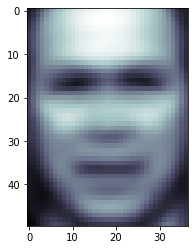

In [6]:
plt.imshow(pca.mean_.reshape((h, w)),
           cmap=plt.cm.bone)

# Features which discriminates the faces

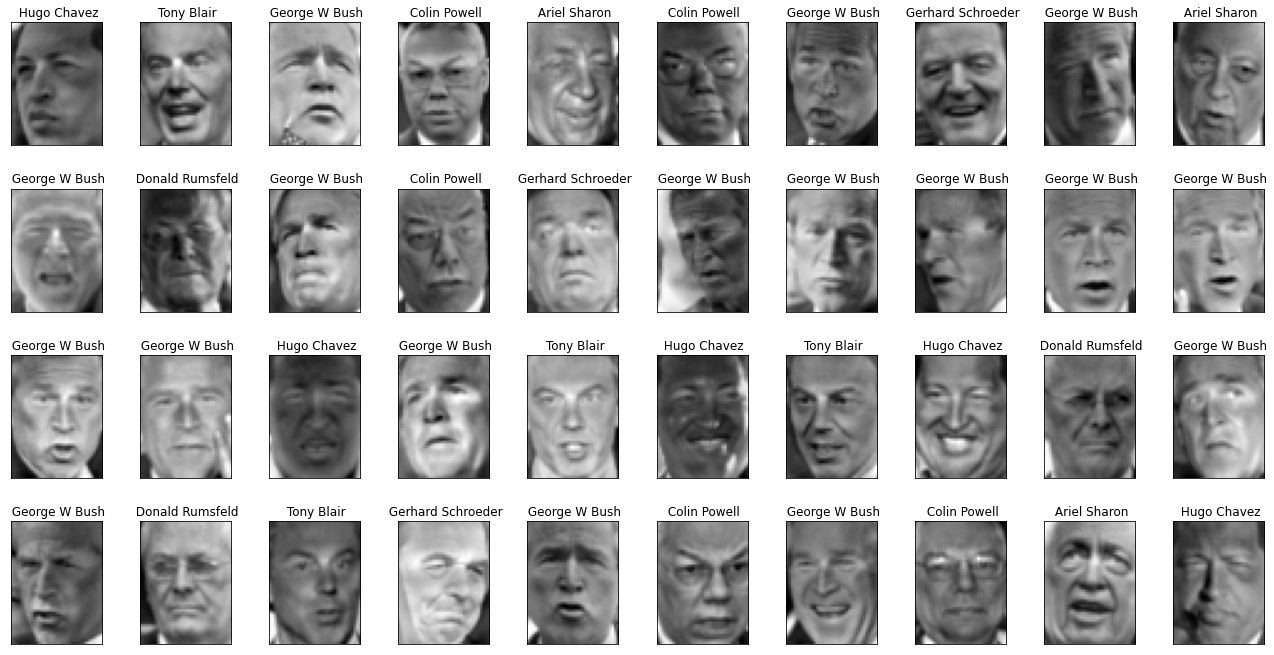

In [7]:
plot_gallery((X-pca.mean_), true_titles, h, w)

# Plot Eigenfaces along with their variences

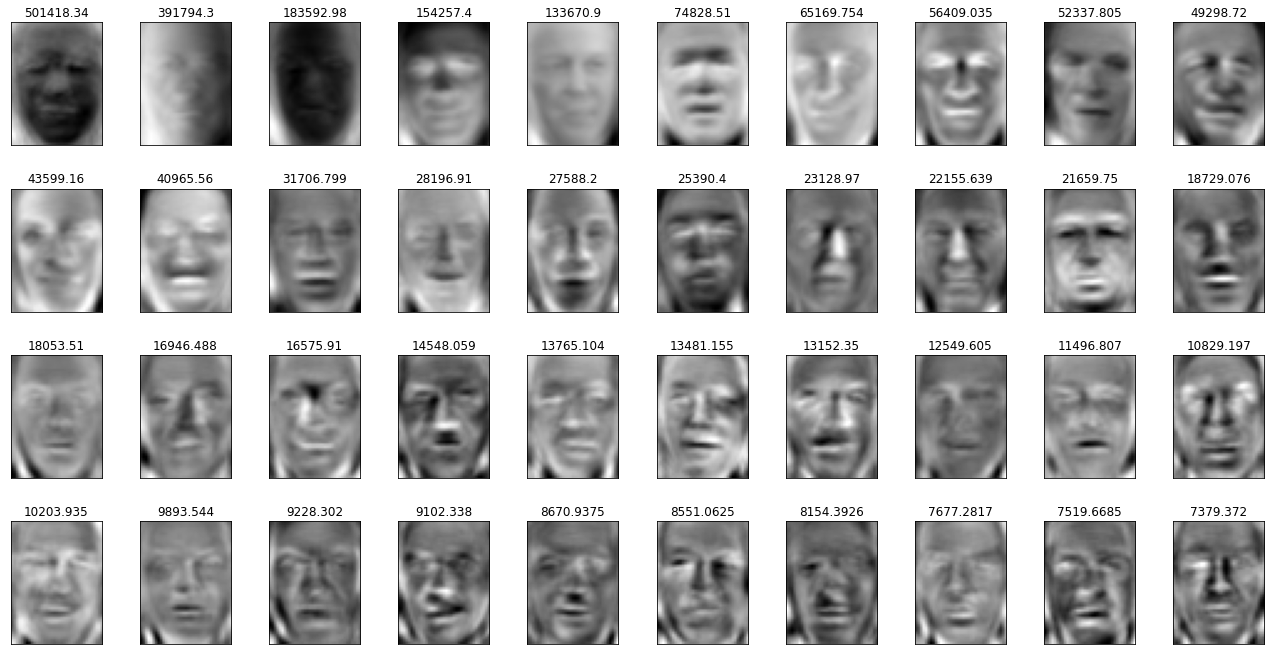

In [8]:
eigenfaces = pca.components_.reshape((n_components, h, w)) #Principal axes in feature space, representing the directions of maximum variance in the data.
eigenvarience=pca.explained_variance_
#eigenfaces.shape
plot_gallery(eigenfaces,eigenvarience,h,w)



# Plot the variences

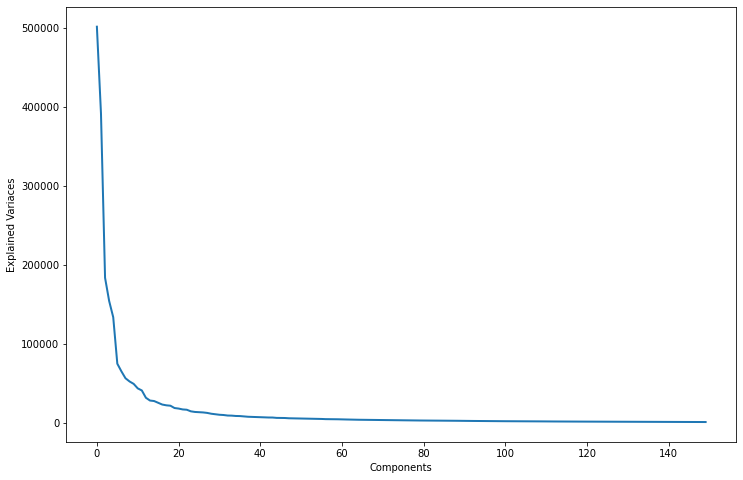

In [9]:
plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

# Transform the images into PC

In [10]:
print("Projecting the input data on the eigenfaces orthonormal basis")

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)




Projecting the input data on the eigenfaces orthonormal basis


# PCA Projection

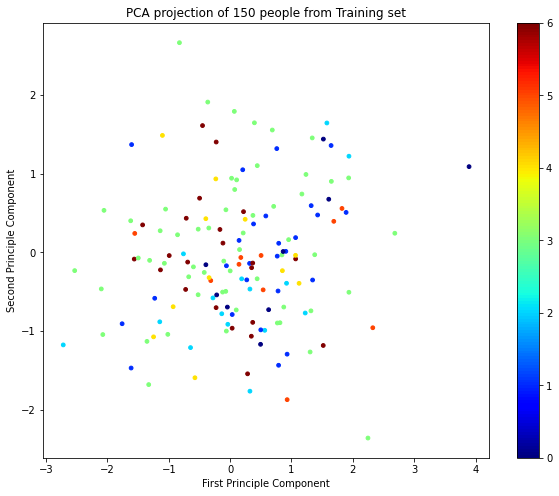

In [11]:
number_of_people=150
index_range=number_of_people
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
scatter=ax.scatter(X_train_pca[:index_range,0],
            X_train_pca[:index_range,1], 
            c=y_train[:index_range],
            s=14,
           cmap=plt.get_cmap('jet', number_of_people)
          )

ax.set_xlabel("First Principle Component")
ax.set_ylabel("Second Principle Component")
ax.set_title("PCA projection of {} people from Training set".format(number_of_people))

fig.colorbar(scatter)

In [12]:
print("Sample Data point after applying PCA\n", X_train_pca[0])
print("-----------------------------------------------------")
print("Dimensions of training set = % s and Test Set = % s"%(
		X_train.shape, X_test.shape))


Sample Data point after applying PCA
 [-2.075602   -1.045793    2.1269364   0.03682863 -0.7575748  -0.5173677
  0.8555041   1.0519382   0.457736    0.01347802 -0.03962535  0.6387268
  0.4816751   2.3378782   1.7784176   0.13310058 -2.2713084  -4.4569736
  2.0976396  -1.1379216   0.18846981 -0.334986    1.125453   -0.3240307
  0.14097627  1.0769366   0.75881255 -0.09978505  3.1199446   0.88379025
 -0.8933784   1.1595999   1.4307376   1.6855657   1.3434724  -1.2591379
 -0.6391327  -2.3362975  -0.01367521 -1.4638394  -0.468925   -1.0547757
 -1.3328588   1.1363764   2.222473   -1.8014412  -0.3063248  -1.0284424
  4.7735095   3.4598377   1.9260311  -1.3513218  -0.25901505  2.0104928
 -1.0562531   0.36118734  1.1707792   0.75714314  0.9009072   0.5996085
 -0.4655595   2.0977905   1.34578     1.9333102   5.0665636  -0.7055079
  0.6071336  -0.90071887 -0.21481328 -2.1068337  -1.6822946  -0.19869693
 -1.7481143  -3.0543482   2.0497444   0.39361888  0.12904103  1.2107102
 -0.7954032  -1.3936491 

# Recognition Task

In [13]:
from tqdm.notebook import tqdm
import torch
# Create a device variable which will be used to shift model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a single hidden layer feed-forward neural network a.k.a. Multi-layer perceptron

In [14]:
class FFN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(150, 512)
        self.layer2 = torch.nn.Linear(512, 128)
        self.layer3 = torch.nn.Linear(128, np.unique(y_train).shape[0])
    
    def forward(self, x):
        # Change the activation function and see what effect we get
        x = torch.nn.Tanh()(self.layer1(x))
        x = torch.nn.Tanh()(self.layer2(x))
        x = torch.nn.Softmax()(self.layer3(x))
        return x

# Generate a pytorch dataloader for our training data

In [15]:
# from keras.utils import to_categorical

# y_train_cat=to_categorical(y_train,num_classes=np.unique(y_train).shape[0])
# y_test_cat=to_categorical(y_test,num_classes=np.unique(y_train).shape[0])
#print(y_train.shape)

# First create a pytorch dataset from the numpy data
dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train_pca), torch.from_numpy(y_train))
# Create a dataloader object which will create batches of data
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)

# Now perform training of the model

In [16]:
from sklearn.metrics import accuracy_score

# Set the number of epochs to be used
epochs = 200
# Create the model
model = FFN().to(device)
# Define Loss
loss_function = torch.nn.CrossEntropyLoss()
# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# These two lists will be used to store average loss and accuracy for each epoch
total_loss, acc = list(), list()
# Now write out the training procedure
for epoch in range(epochs):
    print("\n\nEpoch:", epoch+1)
    # Each batch produces a loss, predictions and target
    batch_loss, batch_preds, batch_target = 0, list(), list()
    # For each batch, train the model
    for x, y in tqdm(dataloader_train, total=len(dataloader_train)):
        # Make sure that data is on the same device as the model
        x, y = x.to(device), y.to(device)
        # Remove all previous gradients
        optimizer.zero_grad()
        # Get predictions by performing a forward pass
        preds = model.forward(x.float())
        # Calculate error
        loss = loss_function(preds, y.to(torch.int64))
        # Calculate all the gradients for each layer
        loss.backward()
        # Finall, update the weights
        optimizer.step()
        # Save the loss
        batch_loss+= loss.item()
        # Save the predictions and target
        batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
        batch_target.extend(y.to(torch.int64).cpu().detach().numpy())
    # Calculate average loss
    total_loss.append(batch_loss/len(dataloader_train))
    # Calculate accuracy for this epoch
    acc.append(accuracy_score(batch_target, batch_preds))
    print("Loss:", total_loss[-1], "\tAcc:", acc[-1])



Epoch: 1


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.8807536171328636 	Acc: 0.33229813664596275


Epoch: 2


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.6727405017422092 	Acc: 0.6656314699792961


Epoch: 3


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 1.4448256300341698 	Acc: 0.8095238095238095


Epoch: 4


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 1.2677949320885442 	Acc: 0.8944099378881988


Epoch: 5


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 1.1507188274014382 	Acc: 0.9161490683229814


Epoch: 6


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 1.0444775742869223 	Acc: 0.9151138716356108


Epoch: 7


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.9441750607182903 	Acc: 0.9306418219461697


Epoch: 8


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.858740214378603 	Acc: 0.9347826086956522


Epoch: 9


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.7895686203433622 	Acc: 0.9420289855072463


Epoch: 10


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.7136795136236376 	Acc: 0.94824016563147


Epoch: 11


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.646869461382589 	Acc: 0.9554865424430642


Epoch: 12


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.6034300192709892 	Acc: 0.9575569358178054


Epoch: 13


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.56267035776569 	Acc: 0.9585921325051759


Epoch: 14


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.5184056730039658 	Acc: 0.9585921325051759


Epoch: 15


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.4899387273096269 	Acc: 0.9575569358178054


Epoch: 16


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.463686446028371 	Acc: 0.9585921325051759


Epoch: 17


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.440367684248955 	Acc: 0.9616977225672878


Epoch: 18


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.41161296732964053 	Acc: 0.9596273291925466


Epoch: 19


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.4003221527222664 	Acc: 0.9596273291925466


Epoch: 20


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.36921846866607666 	Acc: 0.9616977225672878


Epoch: 21


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.3644765033837288 	Acc: 0.9627329192546584


Epoch: 22


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.3334757017512475 	Acc: 0.9627329192546584


Epoch: 23


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.3197056175239624 	Acc: 0.9637681159420289


Epoch: 24


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.32790257661573347 	Acc: 0.9575569358178054


Epoch: 25


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.31199256643172235 	Acc: 0.9575569358178054


Epoch: 26


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.3229434855522648 	Acc: 0.9513457556935818


Epoch: 27


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.34887225877854133 	Acc: 0.937888198757764


Epoch: 28


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.37571359642090335 	Acc: 0.9285714285714286


Epoch: 29


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.40659515751946357 	Acc: 0.9213250517598344


Epoch: 30


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.3692818560427235 	Acc: 0.9285714285714286


Epoch: 31


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.3330333992358177 	Acc: 0.9399585921325052


Epoch: 32


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.31617724655135987 	Acc: 0.9461697722567288


Epoch: 33


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.30674639175976476 	Acc: 0.9503105590062112


Epoch: 34


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2785252462471685 	Acc: 0.9554865424430642


Epoch: 35


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.26969889984015494 	Acc: 0.9565217391304348


Epoch: 36


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2639624039011617 	Acc: 0.9565217391304348


Epoch: 37


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2815994391998937 	Acc: 0.9544513457556936


Epoch: 38


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.24743598315023607 	Acc: 0.9585921325051759


Epoch: 39


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.24779538305536394 	Acc: 0.9554865424430642


Epoch: 40


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.23472802653428046 	Acc: 0.9616977225672878


Epoch: 41


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2315777054717464 	Acc: 0.9606625258799172


Epoch: 42


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.22327659519449358 	Acc: 0.9637681159420289


Epoch: 43


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.22055848062999786 	Acc: 0.9637681159420289


Epoch: 44


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2188024157958646 	Acc: 0.9637681159420289


Epoch: 45


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.21523687579939443 	Acc: 0.9637681159420289


Epoch: 46


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20959763084688493 	Acc: 0.9648033126293996


Epoch: 47


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20860136588734965 	Acc: 0.9648033126293996


Epoch: 48


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20500633841560734 	Acc: 0.9648033126293996


Epoch: 49


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2003031322552312 	Acc: 0.9658385093167702


Epoch: 50


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.198999157596019 	Acc: 0.9658385093167702


Epoch: 51


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.19705089782514879 	Acc: 0.9658385093167702


Epoch: 52


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.19494976091288752 	Acc: 0.9658385093167702


Epoch: 53


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1941144842534296 	Acc: 0.9658385093167702


Epoch: 54


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.19253022656325372 	Acc: 0.9658385093167702


Epoch: 55


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.19346043864084828 	Acc: 0.9658385093167702


Epoch: 56


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1904357557575549 	Acc: 0.9658385093167702


Epoch: 57


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1900523807252607 	Acc: 0.9658385093167702


Epoch: 58


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.21019381176560156 	Acc: 0.9658385093167702


Epoch: 59


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1892357969716672 	Acc: 0.9658385093167702


Epoch: 60


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.18650104165557893 	Acc: 0.9658385093167702


Epoch: 61


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.18574170263544207 	Acc: 0.9658385093167702


Epoch: 62


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.18517814180062664 	Acc: 0.9658385093167702


Epoch: 63


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1836603281478728 	Acc: 0.9658385093167702


Epoch: 64


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1806667550436912 	Acc: 0.9668737060041408


Epoch: 65


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.18406239043801062 	Acc: 0.9668737060041408


Epoch: 66


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1792607634298263 	Acc: 0.9668737060041408


Epoch: 67


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.17768012215533563 	Acc: 0.9668737060041408


Epoch: 68


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.17657924058937258 	Acc: 0.9668737060041408


Epoch: 69


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.17539906345548167 	Acc: 0.9668737060041408


Epoch: 70


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.17514265965550177 	Acc: 0.9668737060041408


Epoch: 71


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.17571903068211772 	Acc: 0.9668737060041408


Epoch: 72


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.17453296434494756 	Acc: 0.9668737060041408


Epoch: 73


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.19005325737018738 	Acc: 0.9668737060041408


Epoch: 74


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1697907515110508 	Acc: 0.9679089026915114


Epoch: 75


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.183609738945961 	Acc: 0.9679089026915114


Epoch: 76


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16837290662430948 	Acc: 0.9679089026915114


Epoch: 77


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16781007438417403 	Acc: 0.9679089026915114


Epoch: 78


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.18967685596116127 	Acc: 0.9679089026915114


Epoch: 79


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.16879978223193076 	Acc: 0.9679089026915114


Epoch: 80


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16789665668001097 	Acc: 0.9679089026915114


Epoch: 81


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16733437181720812 	Acc: 0.9679089026915114


Epoch: 82


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16745846790652122 	Acc: 0.9679089026915114


Epoch: 83


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16653549034268625 	Acc: 0.9679089026915114


Epoch: 84


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1660936435744647 	Acc: 0.9679089026915114


Epoch: 85


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16580503938659544 	Acc: 0.9679089026915114


Epoch: 86


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16574827353319815 	Acc: 0.9679089026915114


Epoch: 87


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1656015064086645 	Acc: 0.9679089026915114


Epoch: 88


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16542009288264858 	Acc: 0.9679089026915114


Epoch: 89


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16474995798160952 	Acc: 0.9679089026915114


Epoch: 90


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16388428493613197 	Acc: 0.9679089026915114


Epoch: 91


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1658310921442124 	Acc: 0.9679089026915114


Epoch: 92


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1896674633026123 	Acc: 0.9679089026915114


Epoch: 93


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16472577021246956 	Acc: 0.9679089026915114


Epoch: 94


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1611557075934064 	Acc: 0.968944099378882


Epoch: 95


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.18068897453767638 	Acc: 0.968944099378882


Epoch: 96


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16112142957506642 	Acc: 0.968944099378882


Epoch: 97


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16144950832090071 	Acc: 0.968944099378882


Epoch: 98


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1604645412054754 	Acc: 0.968944099378882


Epoch: 99


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1601451742913454 	Acc: 0.968944099378882


Epoch: 100


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.17948802860994492 	Acc: 0.968944099378882


Epoch: 101


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.15976515171989317 	Acc: 0.968944099378882


Epoch: 102


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.18612984261445462 	Acc: 0.968944099378882


Epoch: 103


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.16119497587844248 	Acc: 0.968944099378882


Epoch: 104


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.15870710756749876 	Acc: 0.968944099378882


Epoch: 105


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.15922440684610797 	Acc: 0.968944099378882


Epoch: 106


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1586612757415541 	Acc: 0.968944099378882


Epoch: 107


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.15833026068585535 	Acc: 0.968944099378882


Epoch: 108


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1578782077037519 	Acc: 0.968944099378882


Epoch: 109


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20144597014352197 	Acc: 0.968944099378882


Epoch: 110


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1582086313996584 	Acc: 0.968944099378882


Epoch: 111


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.15765255671595374 	Acc: 0.968944099378882


Epoch: 112


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.15925138425682822 	Acc: 0.968944099378882


Epoch: 113


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1572959079977966 	Acc: 0.968944099378882


Epoch: 114


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.1648134407737563 	Acc: 0.968944099378882


Epoch: 115


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.15674788685094926 	Acc: 0.968944099378882


Epoch: 116


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.16697957414773204 	Acc: 0.9668737060041408


Epoch: 117


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.3445693185973552 	Acc: 0.927536231884058


Epoch: 118


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.5230016689146718 	Acc: 0.8933747412008282


Epoch: 119


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.47581100283611205 	Acc: 0.8933747412008282


Epoch: 120


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.426969078519652 	Acc: 0.9057971014492754


Epoch: 121


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.41860403372876104 	Acc: 0.9057971014492754


Epoch: 122


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.411539844327396 	Acc: 0.9099378881987578


Epoch: 123


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.36264922337666633 	Acc: 0.9265010351966874


Epoch: 124


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.350852990583066 	Acc: 0.9337474120082816


Epoch: 125


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2842822562782995 	Acc: 0.9389233954451346


Epoch: 126


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.27561063667939556 	Acc: 0.9420289855072463


Epoch: 127


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.29579176056769585 	Acc: 0.9420289855072463


Epoch: 128


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.26491904751427714 	Acc: 0.9440993788819876


Epoch: 129


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2643453979924802 	Acc: 0.9451345755693582


Epoch: 130


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2635313657022292 	Acc: 0.9451345755693582


Epoch: 131


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2692054579815557 	Acc: 0.9451345755693582


Epoch: 132


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.25035323575139046 	Acc: 0.9472049689440993


Epoch: 133


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.24529943987727165 	Acc: 0.94824016563147


Epoch: 134


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.26835602053230806 	Acc: 0.94824016563147


Epoch: 135


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.24422139085588918 	Acc: 0.94824016563147


Epoch: 136


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.24344503458949826 	Acc: 0.94824016563147


Epoch: 137


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.24435433084445615 	Acc: 0.94824016563147


Epoch: 138


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.24284655805076322 	Acc: 0.94824016563147


Epoch: 139


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.24234183721484676 	Acc: 0.94824016563147


Epoch: 140


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.23642061109985074 	Acc: 0.9492753623188406


Epoch: 141


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.23748151273016008 	Acc: 0.94824016563147


Epoch: 142


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.23820329469538504 	Acc: 0.9492753623188406


Epoch: 143


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2348855795158494 	Acc: 0.9492753623188406


Epoch: 144


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.23726537102653134 	Acc: 0.94824016563147


Epoch: 145


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2465310617079658 	Acc: 0.9451345755693582


Epoch: 146


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.23775442437298835 	Acc: 0.94824016563147


Epoch: 147


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.24431569682013604 	Acc: 0.94824016563147


Epoch: 148


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2694175478912169 	Acc: 0.9409937888198758


Epoch: 149


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.30886936392034253 	Acc: 0.9399585921325052


Epoch: 150


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.315128427239195 	Acc: 0.9389233954451346


Epoch: 151


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2591706096164642 	Acc: 0.943064182194617


Epoch: 152


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.23532428243948567 	Acc: 0.9513457556935818


Epoch: 153


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.23126485234787386 	Acc: 0.9513457556935818


Epoch: 154


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.24554597273949655 	Acc: 0.953416149068323


Epoch: 155


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.23704875921530108 	Acc: 0.953416149068323


Epoch: 156


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2214051707377357 	Acc: 0.953416149068323


Epoch: 157


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.21580522255070747 	Acc: 0.953416149068323


Epoch: 158


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2145961544686748 	Acc: 0.9544513457556936


Epoch: 159


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.21351348668817552 	Acc: 0.9544513457556936


Epoch: 160


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.21225354471994984 	Acc: 0.9544513457556936


Epoch: 161


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.21176620969368565 	Acc: 0.9544513457556936


Epoch: 162


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.21123674559977748 	Acc: 0.9544513457556936


Epoch: 163


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.210339990835036 	Acc: 0.9544513457556936


Epoch: 164


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.208611567414576 	Acc: 0.9544513457556936


Epoch: 165


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20941947905286665 	Acc: 0.9544513457556936


Epoch: 166


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2278826020417675 	Acc: 0.9544513457556936


Epoch: 167


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20860725893608986 	Acc: 0.9544513457556936


Epoch: 168


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20804773427305684 	Acc: 0.9544513457556936


Epoch: 169


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20896997987743346 	Acc: 0.9544513457556936


Epoch: 170


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20707684887513036 	Acc: 0.9544513457556936


Epoch: 171


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.22092497012307566 	Acc: 0.9544513457556936


Epoch: 172


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20662107102332578 	Acc: 0.9544513457556936


Epoch: 173


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2076553355061239 	Acc: 0.9544513457556936


Epoch: 174


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2060384197581199 	Acc: 0.9544513457556936


Epoch: 175


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2061643757887425 	Acc: 0.9544513457556936


Epoch: 176


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2052480630095928 	Acc: 0.9544513457556936


Epoch: 177


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20504254835747904 	Acc: 0.9544513457556936


Epoch: 178


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2441371384887926 	Acc: 0.9544513457556936


Epoch: 179


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.21551403535469885 	Acc: 0.9544513457556936


Epoch: 180


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2038360974120517 	Acc: 0.9544513457556936


Epoch: 181


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2314956465796117 	Acc: 0.9544513457556936


Epoch: 182


C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2032435945565662 	Acc: 0.9544513457556936


Epoch: 183


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.24499696775549842 	Acc: 0.9544513457556936


Epoch: 184


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20334127809732191 	Acc: 0.9554865424430642


Epoch: 185


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20274819211373407 	Acc: 0.9554865424430642


Epoch: 186


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20267568696891108 	Acc: 0.9554865424430642


Epoch: 187


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20260633552266705 	Acc: 0.9554865424430642


Epoch: 188


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.22440643199989874 	Acc: 0.9554865424430642


Epoch: 189


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20219777884983248 	Acc: 0.9554865424430642


Epoch: 190


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20248992548834893 	Acc: 0.9554865424430642


Epoch: 191


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20563760760330385 	Acc: 0.9554865424430642


Epoch: 192


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.21940705378449732 	Acc: 0.9554865424430642


Epoch: 193


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20147082870525698 	Acc: 0.9554865424430642


Epoch: 194


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20172181785587343 	Acc: 0.9554865424430642


Epoch: 195


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.19642859625239525 	Acc: 0.9565217391304348


Epoch: 196


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2159972920292808 	Acc: 0.9565217391304348


Epoch: 197


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.2157394946102173 	Acc: 0.9565217391304348


Epoch: 198


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.19563418758972997 	Acc: 0.9565217391304348


Epoch: 199


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.20907407506339012 	Acc: 0.9565217391304348


Epoch: 200


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


Loss: 0.19559218145666585 	Acc: 0.9565217391304348


# Evaluate the recognition task

In [18]:
from sklearn.metrics import classification_report
y_pred = model(torch.from_numpy(X_test_pca))
print(classification_report(y_test, torch.argmax(y_pred,-1), target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.42      0.62      0.50        13
     Colin Powell       0.76      0.80      0.78        60
  Donald Rumsfeld       0.75      0.78      0.76        27
    George W Bush       0.87      0.83      0.85       146
Gerhard Schroeder       0.82      0.72      0.77        25
      Hugo Chavez       0.48      0.67      0.56        15
       Tony Blair       0.93      0.78      0.85        36

         accuracy                           0.79       322
        macro avg       0.72      0.74      0.72       322
     weighted avg       0.81      0.79      0.79       322



C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


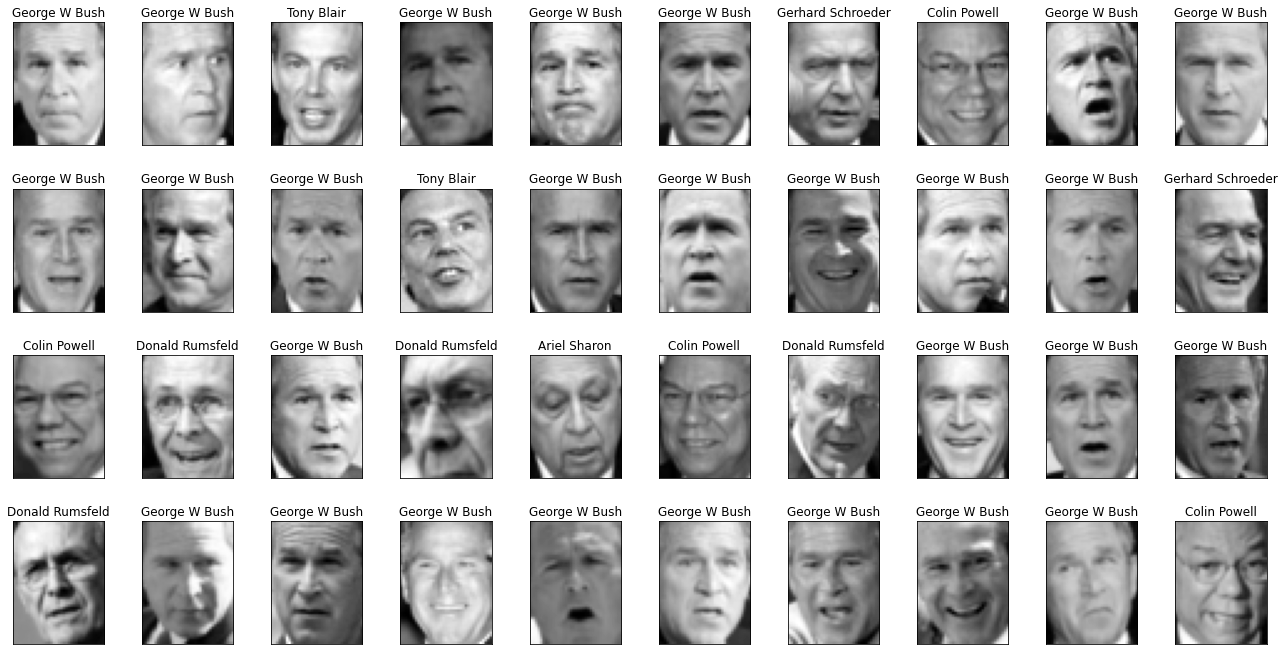

In [19]:
plot_gallery(X_test,target_names[y_test],h,w)

# Predict Using the trained Model

In [20]:
pred=model(torch.from_numpy(X_test_pca[2]))
target_names[torch.argmax(pred,-1)]

C:\Users\Deepayan\AppData\Local\Temp\ipykernel_2528\2527952310.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.layer2(x))


'Tony Blair'